## MONAI Documentation

MONAI (Medical Open Network for AI) is a PyTorch-based open-source framework for deep learning in healthcare imaging. It provides a comprehensive set of tools and utilities for developing and deploying medical imaging applications. MONAI simplifies the process of working with medical imaging data by offering a high-level API that abstracts away the complexities of data loading, preprocessing, augmentation, and model training. (https://monai.io).

This documentation will focus on creating a notebook that show an example of an end-to-end workflow of how to use MONAI's tools to in our research work of medical imaging analysis.

### OUTLINE
The documentation will have six sections, where each section representing a stage/block of the image analysis workflow presented in the below block diagram. For the initial draft of the documentation, the focus will be on the main (blue) pipeline.

<img src="./img/sketch.png" alt="Initial Sketch - Temp" style="width:800px;height:370px;">


#### 0. Installation

In [1]:
# #Installing all the necessary (and optional) libraries that are required with MONAI
# !pip3 install -r https://raw.githubusercontent.com/Project-MONAI/MONAI/dev/requirements-dev.txt

#Installing only the required libraries for MONAI
!pip3 install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0" 2>&1;
!pip3 install -U pip > /dev/null 2>&1;
!pip3 install -U matplotlib > /dev/null 2>&1;
!pip3 install -U notebook > /dev/null 2>&1;

In [2]:
#Imports
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
);
from monai.utils import set_determinism;


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/husainalyusuf/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Use

#### 1. Dowload a Dataset (Example: MedNIST)

In [3]:
#create a directory to store the data
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/9_/y8bpd15944sfjqz0w2vjfdk40000gp/T/tmpe1_wvcj7


In [4]:
# download the MedNIST dataset
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:12, 5.05MB/s]                              


Downloaded: /var/folders/9_/y8bpd15944sfjqz0w2vjfdk40000gp/T/tmpe1_wvcj7/MedNIST.tar.gz
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Writing into directory: /var/folders/9_/y8bpd15944sfjqz0w2vjfdk40000gp/T/tmpe1_wvcj7.


#### 1.1 Explore the Dataset

In [7]:
os.listdir(data_dir) # listing the contents of the data_dir directory, each sub-directory represents a class

['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'README.md', 'AbdomenCT', 'CXR']

In [11]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

# Import the images into an array of arrays. Each sub-array contains the file paths of images for a specific class
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

# Count the number of images in each class
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size # get the dimensions of the images

# Display the dataset information
print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


Visualizing some random images from the dataset

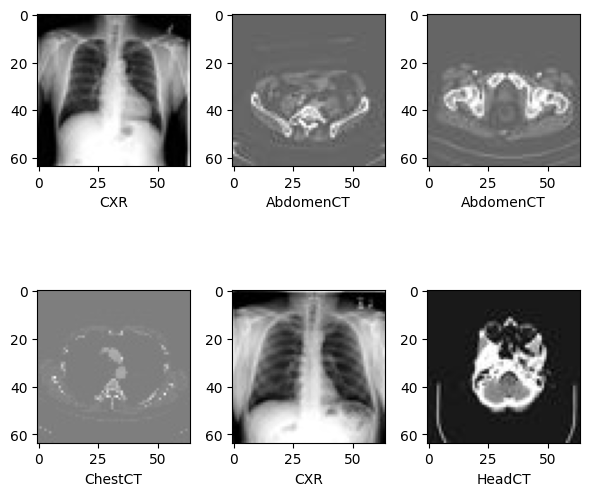

In [20]:
plt.subplots(2, 3, figsize=(6, 6))
for i, k in enumerate(np.random.randint(num_total, size=6)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(2, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### 2. Data Preparation & Transformation

#### 2.1 Split the Dataset
We are going to use `monai.data.partition_dataset_classes()` function. This function can split the dataset into N partitions, according to a defined ratio. More details can be found [here](https://docs.monai.io/en/0.5.0/data.html?highlight=partition#partition-dataset-based-on-classes).

We want to split the data into 3 different sets, one for training, one for validation, and one for testing. We'll use a ratio of 80/10/10 for those sets.


In [22]:
set_determinism(seed=0)

train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), image_class,(8, 1, 1), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


#### 2.2 Data Transformation
we are using `monai.transform` to transform the created partitions - more details can be found [here](https://docs.monai.io/en/0.5.0/transforms.html)

### 3. Data Loading


### 4. Training

### 5. Inference

### 6. Evaluation